In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

**Load and Clean/Prepare Data**

In [31]:
# Load your dataset
df = pd.read_csv('data/earthquake_data.csv')

# Drop duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['Magnitude', 'Epoch(UTC)', 'Lat', 'Lon', 'Depth Km'], inplace=True)

# Drop rows with invalid timestamps or missing depth
df = df.dropna(subset=['Depth Km', 'Epoch(UTC)', 'Lat', 'Lon', 'Magnitude'])

# Drop non-numeric or irrelevant columns
df = df.drop(columns=['Evid', 'Time Local', 'Distance From', 'Magnitude Type'])

# Convert time fields
df['Epoch(UTC)'] = pd.to_datetime(df['Epoch(UTC)'], unit='s', errors='coerce')
df['Time UTC'] = pd.to_datetime(df['Time UTC'], errors='coerce')

# Drops invalid dates from 'Time UTC' and 'Epoch(UTC)'
df = df.dropna(subset=['Time UTC', 'Epoch(UTC)'])


In [32]:
# Extract time features
df['hour'] = df['Epoch(UTC)'].dt.hour
df['day'] = df['Epoch(UTC)'].dt.day
df['month'] = df['Epoch(UTC)'].dt.month
df['year'] = df['Epoch(UTC)'].dt.year

# Define the features and the target
X = df[['Magnitude', 'Lat', 'Lon', 'hour', 'day', 'month', 'year']]
y = df['Depth Km']

**Train and Predict Earthquake Depth**

In [33]:
# Train Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [34]:
# Evuate Performance. Compare y_pred to X_test
y_pred = model.predict(X_test)

print('Earthquake Depth Based On Input Features')
print(y_pred)

print("RMSE:", np.sqrt(root_mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

Earthquake Depth Based On Input Features
[6.2317212  5.25492651 7.28323577 ... 6.1437522  8.93332037 2.46520064]
RMSE: 2.85387525695171
R² Score: 0.2451539653561956


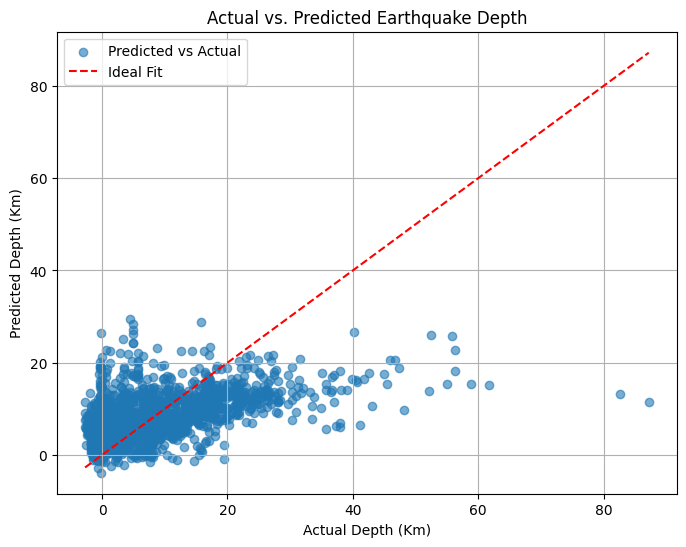

In [35]:
# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Depth (Km)")
plt.ylabel("Predicted Depth (Km)")
plt.title("Actual vs. Predicted Earthquake Depth")
plt.legend()
plt.grid(True)
plt.show()

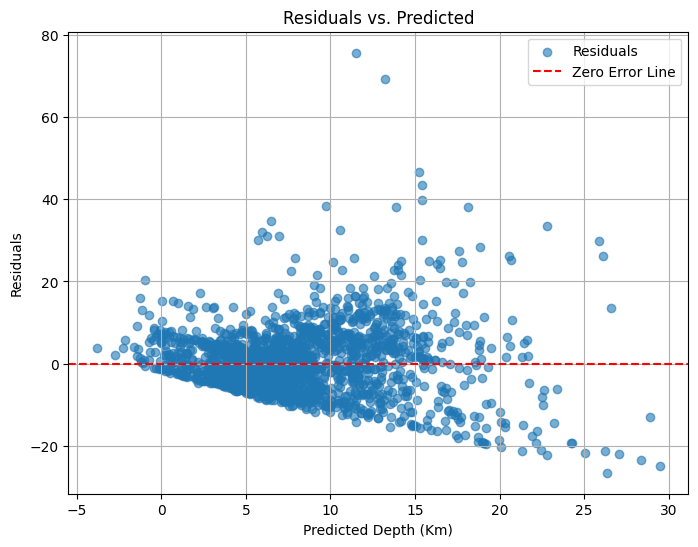

In [36]:
# Residual Plot - Helps Detect Bias
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel("Predicted Depth (Km)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

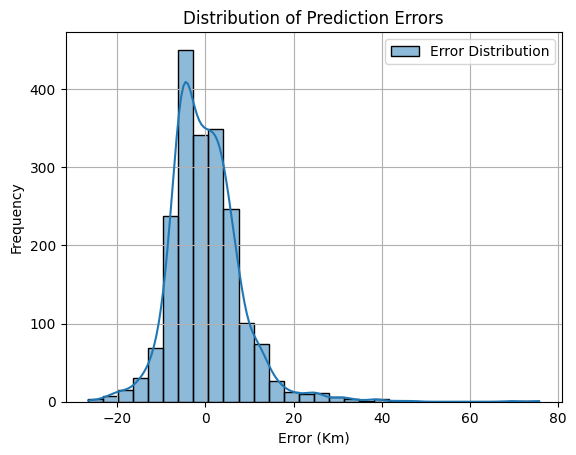

In [37]:
# Prediction Error Distribution - Spot outliers
sns.histplot(residuals, kde=True, bins=30, label='Error Distribution')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Km)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

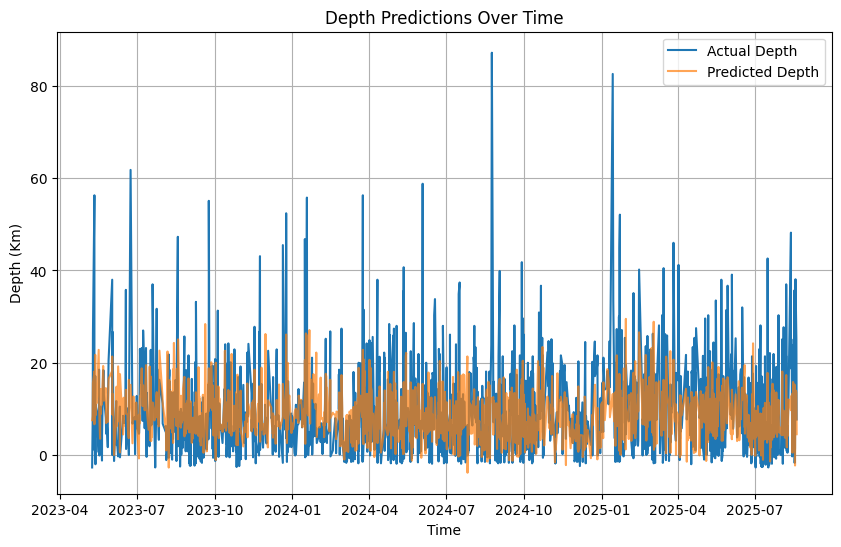

In [38]:
# Time-Based Prediction Plot
df_results = X_test.copy()
df_results['Actual'] = y_test
df_results['Predicted'] = y_pred
df_results['Epoch'] = df.loc[X_test.index, 'Epoch(UTC)']

df_results.sort_values('Epoch', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_results['Epoch'], df_results['Actual'], label='Actual Depth')
plt.plot(df_results['Epoch'], df_results['Predicted'], label='Predicted Depth', alpha=0.7)
plt.title("Depth Predictions Over Time")
plt.xlabel("Time")
plt.ylabel("Depth (Km)")
plt.legend()
plt.grid(True)
plt.show()

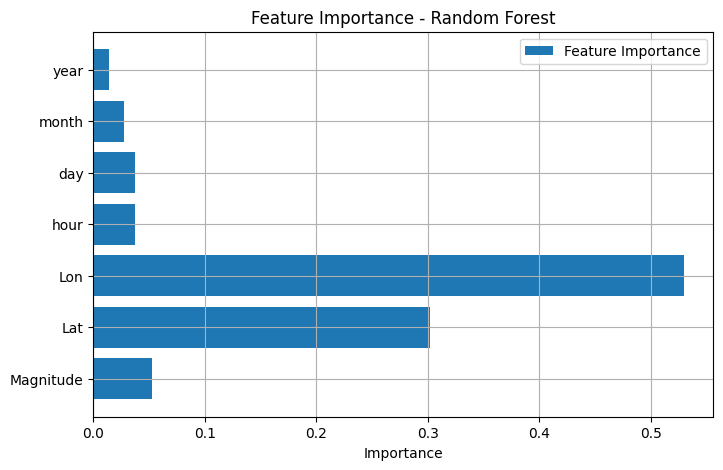

In [39]:
# Visualize feature importance to determine which features influence the predictions.
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
plt.barh(features, importances, label='Feature Importance')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Compare models and evaluate performance of three different
# regression algorithms for earthquake prediction task.

# Dictionary of models
models = {
    'Linear': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model and Compare RMSE score of each model.
# The lower score means the models predictions are closer to the actual values.
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    print(f"{name} RMSE: {rmse:.2f}")

Linear RMSE: 8.14
Random Forest RMSE: 5.67
Gradient Boosting RMSE: 6.18


In [41]:
# Perform hyperparameter tuning for a RandomForestRegressor using GridSearchCV.
# This is a systematic way to find the best combination of model settings for predicting earthquake depth.
# Will optimize model accuracey without overfitting.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Preform exhustive ssearch over param_grid using 5-fold cross-validation
# to evaluate each combination.
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Train and evaluation model configurations using cross-validation above.
grid_search.fit(X_train, y_train)

# Find the one with the lowest RMSE across all folds.
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


**Visualize Feature Combinations**

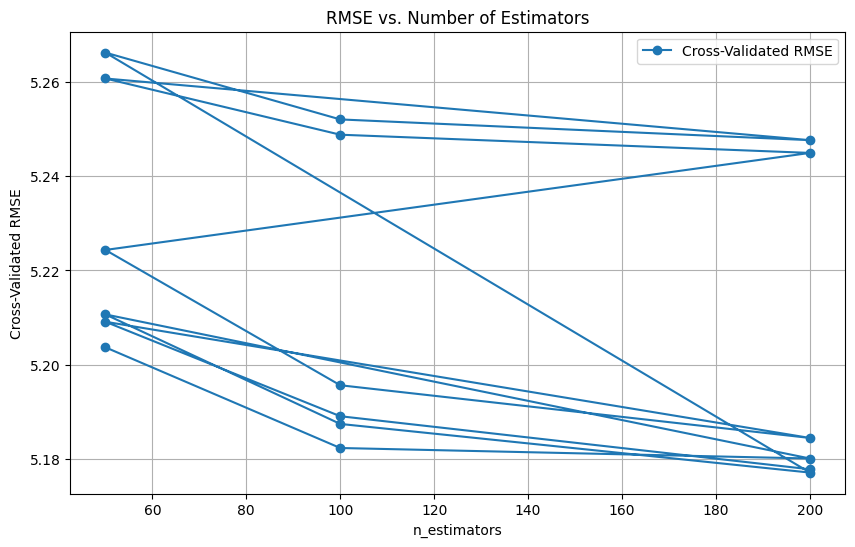

In [42]:
# Visualize how the number of trees affects model performance,
# specifically the cross-validated RMSE
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], -results['mean_test_score'], marker='o', label='Cross-Validated RMSE')
plt.title("RMSE vs. Number of Estimators")
plt.xlabel("n_estimators")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.legend()
plt.show()

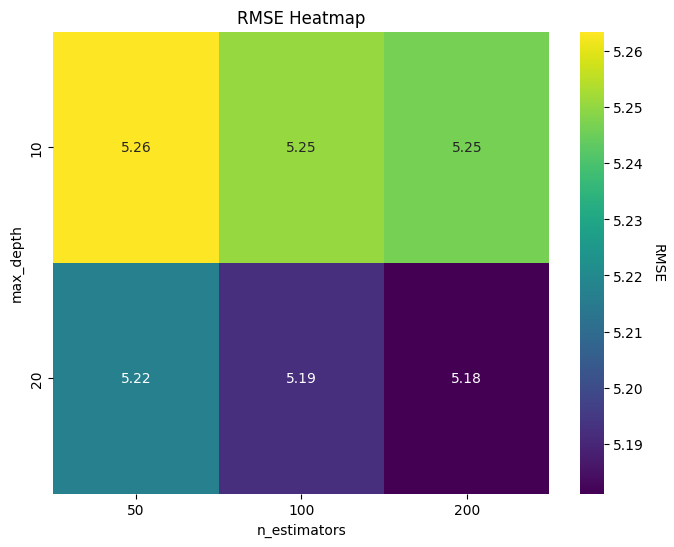

In [43]:
# Generate heatmap visualization to analyze how different
# combinations of max_depth and n_estimators affect the models
# cross-validated RMSE during hyperparameter tuning with GridSearchCV
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(-pivot_table, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("RMSE Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")

colorbar = ax.collections[0].colorbar
colorbar.set_label("RMSE", rotation=270, labelpad=15)

plt.show()

**Perform Hyperparameter tuning using RandomizedSearchCV**

In [44]:
# Perform hyperparameter tuning for a RandomForestRegressor using RandomizedSearchCV. 
# Searches for the best combination of model settings to minimize prediction error.
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 25)),
    'min_samples_split': randint(2, 10)
}

# Samples 20 random combinations from the parameter space 
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Train and evaluation models
random_search.fit(X_train, y_train)

# Return compination with the lowest average RMSE score across all folds.
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'max_depth': 24, 'min_samples_split': 8, 'n_estimators': 171}


**Use Standardization and Polynomial Expansion**

In [45]:
# Prepare feature matrix for a regression model that predicts
# earthquake depth by apply two key preprocessing steps:
# standardization and polynomial expansion
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
print(X_poly)

[[-0.7471355   0.24795683 -0.14408099 ...  0.45300675  0.47057796
   1.14328608]
 [-0.88405123  0.31956401 -0.13800192 ...  0.45300675  0.47057796
   1.14328608]
 [ 0.75893763 -0.20524593  1.66241488 ...  0.45300675  0.47057796
   1.14328608]
 ...
 [ 0.48510615  0.83145182 -0.25173112 ... -0.72284008 -0.57771333
  -1.46249417]
 [-1.15788271  0.28044065 -0.0207266  ... -0.72284008 -0.57771333
  -1.46249417]
 [ 0.21127468 -0.53893681 -0.50375908 ... -0.84042477 -0.57771333
  -1.46249417]]
[[-0.7471355   0.24795683 -0.14408099 ...  0.22144362  0.53800524
   1.30710307]
 [-0.88405123  0.31956401 -0.13800192 ...  0.22144362  0.53800524
   1.30710307]
 [ 0.75893763 -0.20524593  1.66241488 ...  0.22144362  0.53800524
   1.30710307]
 ...
 [ 0.48510615  0.83145182 -0.25173112 ...  0.33375269  0.84490238
   2.13888918]
 [-1.15788271  0.28044065 -0.0207266  ...  0.33375269  0.84490238
   2.13888918]
 [ 0.21127468 -0.53893681 -0.50375908 ...  0.33375269  0.84490238
   2.13888918]]


In [46]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print(y_pred)

[ 7.06675706  4.75568045  3.84128931 ...  7.22178999  7.78451935
 -0.52112215]


In [47]:
# Evaluate per

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 7.88
R² Score: 0.29
